# HW12 Assignment I - SQL and Spatial Data Analysis

This notebook presents an exploratory data analysis of a dataset of hospital facilities Asthma dismissal records using CartoDB, SQL and geopandas. The notebook is based on the PUI 2016 Lab 12 notebook by fedhere. The main work on this notebook instance was:

1) To build the SQL query to retreive the aggregated dismissals by zipcode from CartoDB using the SQL API

2) To find and load a shapefile with the Manhattan zipcopdes, load it into a geodataframe and merge it with the data extracted from Carto

3) Create a semi-variogram based on the data

In [2]:
# Imports to work with with statistical analysis, maps, etc.

%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import ast
from cStringIO import StringIO
import os
import json
import requests
import urllib2
import urllib
import shapely
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

# Using the last development version of geopandas at this time
# pip install git+git://github.com/geopandas/geopandas.git
from geopandas import GeoDataFrame

from fiona.crs import from_epsg
import matplotlib.pylab as pl
from matplotlib import colors

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
pl.rcParams.update(data)
pl.rcParams['font.size']=12

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
# Helper function to query CartoDB using the SQL API
# Function from fedhere reference notebook
# https://github.com/fedhere/PUI2016_fb55/blob/master/HW12_fb55/Assignment%201%20instructions.ipynb

def queryCartoDB(query, format, source):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [6]:
# Preparing query parameters
SQL_SOURCE = 'https://sbg389.carto.com/api/v2/sql'

facilityQuery = '''
SELECT SUM (asthmacount) as count, nycasthma.zipcodes
FROM nycasthma
group by nycasthma.zipcodes
'''

# Use the queryCartoDB helper function to retreive the data in JSON format
# Parse the JSON into a string and load it into a pandas dataframe
facilityStream = queryCartoDB(facilityQuery, format='JSON', source=SQL_SOURCE)
facilityData   = json.loads(facilityStream.read())
facilities     = pd.DataFrame.from_dict(facilityData['rows'])

In [16]:
# Find a shape file with zipcode shapes for NYC, download it and open it with geopandas
# Will download this directly from NYC Open Data Site
# Zip Code Boundaries Dataset
# https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u

fileUrl = "https://data.cityofnewyork.us/api/file_data/" \
"YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?" \
"filename=ZIP_CODE_040114.zip"


if not os.path.isdir(os.getenv("PUIDATA") + "/NYCZIPS"):
    os.system("mkdir " + os.getenv("PUIDATA") + "/NYCZIPS")

if not os.path.isfile("ZIP_CODE_040114.zip"):
    os.system("curl -o ZIP_CODE_040114.zip " + fileUrl)

if not os.path.isfile(os.getenv("PUIDATA") + "/NYCZIPS/ZIP_CODE_040114.zip"):
    os.system("mv ZIP_CODE_040114.zip " + os.getenv("PUIDATA") + "/NYCZIPS/")
    os.system("unzip " + os.getenv("PUIDATA") + "/NYCZIPS/ZIP_CODE_040114.zip"\
              " -d " + os.getenv("PUIDATA") + "/NYCZIPS/")

In [8]:
# Merge the facilities dataframe using the zipcode 
# Use the zipcode geometry centers to extract the x and y coordinates of the zipcode center

# load the shapefile
ct_shape = GeoDataFrame.from_file(os.getenv("PUIDATA") + "/NYCZIPS/ZIP_CODE_040114.shp")

# Create a new column containing the centers of the zips
ct_shape['centers'] = ct_shape.geometry.centroid
ct_shape.rename(columns={'ZIPCODE': 'zipcodes'}, inplace=True)

# Homogenize the data types of the zipcodes columns on each dataframe
facilities.zipcodes = facilities.zipcodes.astype(str)
ct_shape.zipcodes = ct_shape.zipcodes.astype(str)

# Merge the dataframes
merged = pd.merge(facilities, ct_shape, on='zipcodes')

# Select the required columns
merged = merged[['count', 'zipcodes', 'centers']]


In [9]:
merged.head()

,count,zipcodes,centers
0,1699,10461,POINT (1028292.72437689 247902.4282787614)
1,405,11373,POINT (1017941.215480481 208485.1046661779)
2,1698,10451,POINT (1005358.961284301 238316.0675161843)
3,220,11691,POINT (1050360.772370908 158235.4624321515)
4,246,11375,POINT (1026858.206454871 201880.2234817908)


In [10]:
# Create a 3xN numpy array with x-location, y-location, number of dismissals

# Create an empty array
krigdata = np.zeros((len(merged),3))

# Loop through the dataframe and populate the x,y and count
for x in range(0, len(merged)):
    krigdata[x][0] = merged.centers[x].x
    krigdata[x][1] = merged.centers[x].y
    krigdata[x][2] = merged['count'][x]

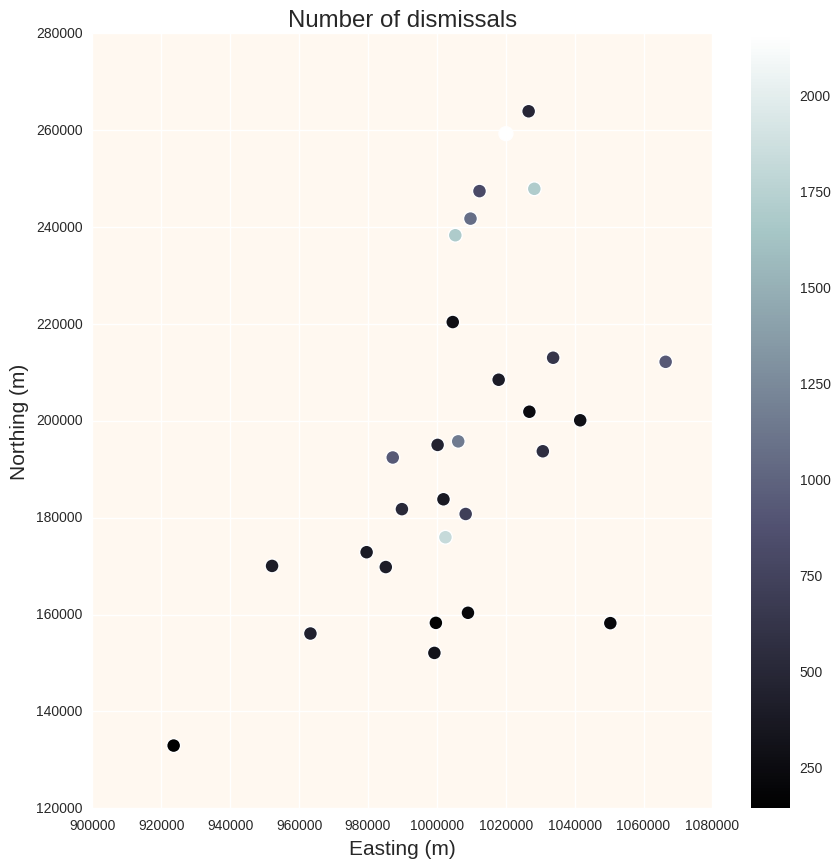

In [11]:
# Plot the dataframe

pl.figure(figsize=(10,10))
pl.scatter(krigdata[:,0], krigdata[:,1], c=krigdata[:,2], s=100, cmap='bone')
pl.xlabel("Easting (m)", fontsize=15)
pl.ylabel("Northing (m)", fontsize=15)
pl.title('Number of dismissals') ;
pl.colorbar()

#### Figure I: This plot presents a color map with the zip-aggregated number of asthma dismissals (lighter represents higher number of dismissals) along with the location of the center of their corresponding zip code (x and y axis).

In [13]:
# Helper functions to create semivariograms
# http://connor-johnson.com/2014/03/20/simple-kriging-in-python/

def SVh( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    '''
    pd = squareform( pdist( P[:,:2] ) )
    N = pd.shape[0]
    Z = list()
    for i in range(N):
        for j in range(i+1,N):
            if( pd[i,j] >= h-bw )and( pd[i,j] <= h+bw ):
                Z.append( ( P[i,2] - P[j,2] )**2.0 )
    return np.sum( Z ) / ( 2.0 * len( Z ) )
 
def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        sv.append( SVh( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T
 
def C( P, h, bw ):
    '''
    Calculate the sill
    '''
    c0 = np.var( P[:,2] )
    if h == 0:
        return c0
    return c0 - SVh( P, h, bw )

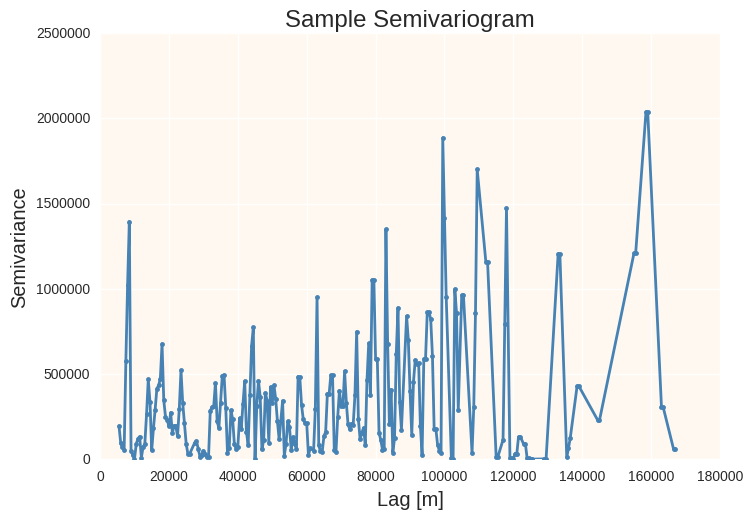

In [14]:
# Create the semivariogram using our krigdata array

# bandwidth, plus or minus 250 meters
bw = 500

# lags in 500 meter increments from zero to 10,000
hs = np.arange(0,1080000,bw)
sv = SV( krigdata, hs, bw )
pl.plot( sv[0], sv[1], '.-' )
pl.xlabel('Lag [m]')
pl.ylabel('Semivariance')
pl.title('Sample Semivariogram') ;
